**Importing Data from .mat files**

In [1]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
                
file_id = '1GMnPjRUju5YzZEWL5bk9qCrf90vXWEqD'
destination = 'data_uav.zip'
download_file_from_google_drive(file_id, destination)

from zipfile import ZipFile

with ZipFile('data_uav.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [2]:

import scipy.io
import numpy as np

num_trajs = 50
n_bs = 4
n_paths = 25
n_time = 3e3
n_features = 6


mat = scipy.io.loadmat('all_rxpower_tensor_paths.mat')
rx_power_tensor = mat['rx_power_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
rx_power_tensor = np.reshape(rx_power_tensor,(int(num_trajs*n_time),n_bs,n_paths))
rx_power_tensor[rx_power_tensor==0] = -np.infty
rx_power_tensor = 10**(0.1*rx_power_tensor) # in Watts


#print(np.sum((rx_power_tensor==0.0)))
#print(10**(-0.1*np.infty))

print(np.min(rx_power_tensor))

0.0


In [3]:
BW = 400e6
k = 1.38e-23
NF = 10**(0.9)
T = 298

NoisePower = k*BW*NF*T


SNRs = rx_power_tensor/NoisePower

SNRs[SNRs==0.0] = 1e-25 # no paths to -250 dB SNR
print(np.sum((SNRs==1e-25)))


54582


In [4]:

import scipy.io
import numpy as np

num_trajs = 50
n_bs = 4
n_paths = 25
n_time = 3e3
n_features = 6

mat = scipy.io.loadmat('all_azimuth_aoa_tensor_paths.mat')
azimuth_aoa_tensor = mat['azimuth_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
azimuth_aoa_tensor = np.reshape(azimuth_aoa_tensor,(int(num_trajs*n_time),n_bs,n_paths))
azimuth_aoa_tensor = azimuth_aoa_tensor + azimuth_aoa_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))



mat = scipy.io.loadmat('all_azimuth_aod_tensor_paths.mat')
azimuth_aod_tensor = mat['azimuth_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
azimuth_aod_tensor = np.reshape(azimuth_aod_tensor,(int(num_trajs*n_time),n_bs,n_paths))
azimuth_aod_tensor = azimuth_aod_tensor + azimuth_aod_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))

mat = scipy.io.loadmat('all_zenith_aod_tensor_paths.mat')
zenith_aod_tensor = mat['zenith_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
zenith_aod_tensor = np.reshape(zenith_aod_tensor,(int(num_trajs*n_time),n_bs,n_paths))
zenith_aod_tensor = zenith_aod_tensor + zenith_aod_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))


mat = scipy.io.loadmat('all_zenith_aoa_tensor_paths.mat')
zenith_aoa_tensor = mat['zenith_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
zenith_aoa_tensor = np.reshape(zenith_aoa_tensor,(int(num_trajs*n_time),n_bs,n_paths))
zenith_aoa_tensor = zenith_aoa_tensor + zenith_aoa_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))

# mat = scipy.io.loadmat('all_rxpower_tensor_paths.mat')
# rx_power_tensor = mat['rx_power_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
# rx_power_tensor = np.reshape(rx_power_tensor,(int(num_trajs*n_time),n_bs,n_paths))
# rx_power_tensor = 10**(0.1*rx_power_tensor) # in Watts

mat = scipy.io.loadmat('all_toa_tensor_paths.mat')
toa_tensor = mat['toa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
toa_tensor = np.reshape(toa_tensor,(int(num_trajs*n_time),n_bs,n_paths))*1e3 #in ms
toa_tensor = toa_tensor + toa_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))

mat = scipy.io.loadmat('all_true_tensor.mat')
true_cord_tensor = mat['true_cord_tensor'] # dimensions are n_traj x n_time x 3
true_cord_tensor = np.reshape(true_cord_tensor,(int(num_trajs*n_time),3))
del mat


**Constructing the input tensor with dimensions n_samples x n_paths x n_bs x n_features**

In [5]:
import math
input_tensor = np.zeros((int(num_trajs*n_time),n_bs,n_paths,n_features))*math.nan

n_samples = int(num_trajs*n_time)


input_tensor[:,:,:,0] = azimuth_aoa_tensor
del azimuth_aoa_tensor

input_tensor[:,:,:,1] = azimuth_aod_tensor
del azimuth_aod_tensor

input_tensor[:,:,:,2] = zenith_aoa_tensor
del zenith_aoa_tensor

input_tensor[:,:,:,3] = zenith_aod_tensor
del zenith_aod_tensor

input_tensor[:,:,:,4] = rx_power_tensor
del rx_power_tensor

input_tensor[:,:,:,5] = toa_tensor
del toa_tensor

print(np.sum(np.isnan(input_tensor))) ## making sure that there are no values left unassigned

0


In [6]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

inputShape = input_tensor.shape[1:]
print(inputShape)
#input_tensor = np.reshape(input_tensor,(n_samples,int(n_bs*n_paths*n_features)))

(4, 25, 6)


**CNN  approach**

In [7]:
from sklearn import preprocessing


input_tensor = input_tensor 
true_cord_tensor = true_cord_tensor - np.min(true_cord_tensor,axis = 0) ## assuming we know the minimum coordinates
#of UE 
true_cord_tensor = true_cord_tensor*1



model = models.Sequential()
model.add(layers.Conv2D(64, (7,7), padding="same", input_shape=inputShape,activation="relu",strides=1))
#model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (5,5), padding="same",activation="relu",strides=1))
#model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(16, (5,5), padding="same",activation="relu",strides=1))
#model.add(layers.Conv2D(16, (5,5), padding="same",activation="relu",strides=1))
#model.add(layers.Dropout(0.2))
# model.add(layers.Conv2D(32, (3,3), padding="same",activation="relu"))
# model.add(layers.Dropout(0.2))
# model.add(layers.Conv2D(32, (3,3), padding="same",activation="relu"))
# model.add(layers.Dropout(0.2))
# model.add(layers.Conv2D(32, (5,5), padding="same",activation="relu"))
# model.add(layers.Dropout(0.2))
# model.add(layers.Conv2D(32, (5,5), padding="same",activation="relu"))
# model.add(layers.Dropout(0.2))
# model.add(layers.Conv2D(8, (3, 3), padding="same",activation="relu"))
# model.add(layers.Dropout(0.2))
#model.add(layers.Dense(64,activation = 'relu'))
model.add(layers.Flatten())
#model.add(layers.Dropout(0.2))
# model.add(layers.Dense(16,activation = 'relu'))
#model.add(layers.Dense(16,activation = 'relu'))
model.add(layers.Dense(3,activation = 'relu'))
print(model.summary())
opt = tf.keras.optimizers.Adam()
model.compile(loss='mse', optimizer=opt)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 25, 64)         18880     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 25, 32)         51232     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 25, 16)         12816     
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 4803      
Total params: 87,731
Trainable params: 87,731
Non-trainable params: 0
_________________________________________________________________
None


In [8]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.reshape(input_tensor,(n_samples,int(n_bs*n_paths*n_features))), true_cord_tensor, test_size=0.5)


scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit(X_train)
scaled_df = scaler.transform(X_train)

# outScaler = preprocessing.StandardScaler()
# y_train_scaled = outScaler.fit(y_train)
# y_train_scaled = outScaler.transform(y_train)

scaled_df = np.reshape(scaled_df,(scaled_df.shape[0],n_bs,n_paths,n_features))
print(scaled_df.shape)
# print(np.min(y_train_scaled))

(75000, 4, 25, 6)


In [9]:
model.fit(scaled_df,y_train, epochs=300, batch_size=32, verbose = 2)

Epoch 1/300
2344/2344 - 36s - loss: 3624.7053
Epoch 2/300
2344/2344 - 5s - loss: 799.2570
Epoch 3/300
2344/2344 - 5s - loss: 572.3821
Epoch 4/300
2344/2344 - 6s - loss: 388.3453
Epoch 5/300
2344/2344 - 6s - loss: 293.5453
Epoch 6/300
2344/2344 - 6s - loss: 240.7262
Epoch 7/300
2344/2344 - 6s - loss: 195.6544
Epoch 8/300
2344/2344 - 6s - loss: 170.1589
Epoch 9/300
2344/2344 - 6s - loss: 137.7402
Epoch 10/300
2344/2344 - 6s - loss: 117.0712
Epoch 11/300
2344/2344 - 6s - loss: 99.3119
Epoch 12/300
2344/2344 - 6s - loss: 91.4878
Epoch 13/300
2344/2344 - 5s - loss: 77.6610
Epoch 14/300
2344/2344 - 5s - loss: 69.2875
Epoch 15/300
2344/2344 - 5s - loss: 66.4863
Epoch 16/300
2344/2344 - 5s - loss: 57.9600
Epoch 17/300
2344/2344 - 5s - loss: 53.7480
Epoch 18/300
2344/2344 - 6s - loss: 50.5825
Epoch 19/300
2344/2344 - 6s - loss: 47.2119
Epoch 20/300
2344/2344 - 5s - loss: 46.4486
Epoch 21/300
2344/2344 - 5s - loss: 42.5335
Epoch 22/300
2344/2344 - 5s - loss: 39.0984
Epoch 23/300
2344/2344 - 5s -

In [10]:
scaled_input = np.reshape(input_tensor,(n_samples,int(n_bs*n_paths*n_features)))
scaled_input = scaler.transform(scaled_input)
scaled_input = np.reshape(scaled_input,(scaled_input.shape[0],n_bs,n_paths,n_features))
pred_vals = model.predict(scaled_input) +  np.min(true_cord_tensor)*0


# pred_train = model.predict(scaled_df)
# scaled_test =scaler.transform(X_test)
# scaled_test = np.reshape(scaled_test,(scaled_test.shape[0],n_bs,n_paths,n_features))
# pred_test = model.predict(scaled_test)

In [11]:
print(X_test.shape)
#pred_vals = scaler.inverse_transform(pred_vals)
#pred_train = scaler.inverse_transform(pred_train)
#pred_test = scaler.inverse_transform(pred_test)

(75000, 600)


In [12]:
#pred_vals = outScaler.inverse_transform(pred_vals)
norm_error = np.linalg.norm(pred_vals - true_cord_tensor,axis = 1)
# norm_error_train = np.linalg.norm(pred_train - y_train,axis = 1)
# norm_error_test = np.linalg.norm(pred_test - y_test,axis = 1)
# print(norm_error.shape)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


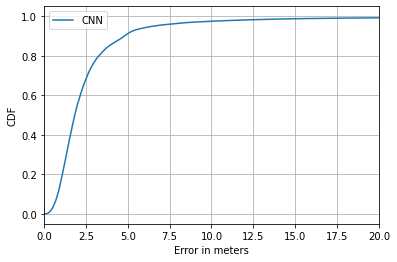

In [13]:
from statsmodels.distributions.empirical_distribution import ECDF

cdf = ECDF(norm_error/1)
plt.plot(cdf.x,cdf.y)
plt.grid()
plt.xlim([0,20])

# cdf = ECDF(norm_error_train/1)
# plt.plot(cdf.x,cdf.y)
# plt.grid()
# plt.xlim([0,20])


# cdf = ECDF(norm_error_test/1)
# plt.plot(cdf.x,cdf.y)
# plt.grid()
# plt.xlim([0,6])


# mat = scipy.io.loadmat('overall_DNN.mat')
# err_data = mat['norm_error']
# err_data = (err_data).flatten()
# cdf = ECDF(err_data*1)
# plt.plot(cdf.x,cdf.y)


# mat = scipy.io.loadmat('baselineerror.mat')
# err_data = mat['err_data']
# err_data = (err_data).flatten()
# cdf = ECDF(err_data*1)
# plt.plot(cdf.x,cdf.y)



plt.xlabel('Error in meters')
plt.ylabel('CDF')
plt.legend(['CNN','NN','baseline'])

In [14]:
print(np.mean(norm_error))

2.765717379489687


In [15]:
cdf = ECDF(norm_error/1)
y = cdf.y
indx = cdf.x[y>0.8]
#print(" {0}":)
print("The 80% percentile error in meters is ", indx[0], end='')

The 80% percentile error in meters is  3.2769808585927205